<style>
    .title_container {
        margin: auto;
        background: rgb(81,92,103);
        background: linear-gradient(90deg, rgba(81,92,103,1) 36%, rgba(12,35,66,1) 62%);
        border-radius: 7px;
        color: white;
        text-align:center;
        width:75%;
        padding-top:2%;
        padding-bottom:2%;
    }
    
    .question_container {
        margin: auto;
        background: rgb(84,138,142);
        background: linear-gradient(90deg, rgba(84,138,142,1) 41%, rgba(145,201,73,1) 81%);
        border-radius: 7px;
        color: white;
        text-align:left;
        width:75%;
        padding-top:1%;
        padding-bottom:1%;
        padding-left: 2%;
        margin-top:2%;
    }
    
    .question_container p {
        font-size: 16px;
    }
    
    .alert_container {
        margin: auto;
        background: rgb(142,94,84);
        background: linear-gradient(128deg, rgba(142,94,84,1) 13%, rgba(201,103,73,1) 69%);
        border-radius: 7px;
        color: white;
        text-align:left;
        width:75%;
        padding-top:1%;
        padding-bottom:1%;
        padding-left: 2%;
        margin-top:2%;
    }
    
    .alert_container p {
        font-size: 16px;
    }
    
    .code_span {
        background-color: #E2E7EC;
        padding:2px;
        border-radius:1px;
        font-family: Consolas,monaco,monospace;
        color:black;
    }
</style>

<div class ='title_container'>
    <h1> Análisis de Datos II </h1>
    <h2> Profesor: Oldemar Rodríguez </h2>
    <h3> Estudiante: Jimmy Calvo Monge </h3>
    <h3> Carné: B31281 </h3>
    <hr style='color:white; width:80%;'>
    <h4> TAREA 8 </h4>
    <h4> Fecha de entrega: 16 de Octubre de 2022 </h4>
</div>

Importamos los módulos necesarios para resolver esta tarea.

In [263]:
### Basicos
import numpy as np
import pandas as pd
from pandas import DataFrame

### Utilidades/Varios
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.patches import Circle
from sklearn.tree import export_graphviz
from sklearn import tree
import seaborn as sns
import time
import graphviz
import os

### Training/Testing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### predictPy
from predictPy import Analisis_Predictivo

### Modelos:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global     = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":   precision_global, 
            "Error Global":       error_global, 
            "Precisión por categoría":precision_categoria}

### Clase MatConf de la Tarea 2

class MatConf:
    
    def __init__(self,matriz):
        
        self.mat_conf = matriz
        
        VN = self.mat_conf[0,0]
        VP = self.mat_conf[1,1]
        FP = self.mat_conf[0,1]
        FN = self.mat_conf[1,0]
        
        dict_medidas = {
            'Precisión Global' : (VN+VP)/(VN+FP+FN+VP),
            'Error Global' : (FN+FP)/(VN+FP+FN+VP),
            'Precisión Positiva (PP)' : VP/(FN+VP),
            'Precisión Negativa (PN)' : VN/(VN+FP),
            'Proporción de Falsos Positivos (PFP)' : FP/(VN+FP),
            'Proporción de Falsos Negativos (PFN)' : FN/(FN+VP),
            'Asertividad Positiva (AP)' : VP/(FP+VP),
            'Asertividad Negativa (AN)' : VN/(VN+FN)
        }
        self.dict_medidas = dict_medidas
        
    def __str__(self):
        mensaje="Estos son los resultados para esta matriz de confusion:"
        for key in list(self.dict_medidas.keys()):
            mensaje = mensaje + f"\n - {key}: {self.dict_medidas[key]}"
        return mensaje

<div class='question_container'>
    <h2> Pregunta 1 </h2>
    <p> Complete las demostraciones de los Teoremas 2 y 4 de la presentación de la clase. </p>
</div>

**Respuesta** Para el primer teorema (Teorema 2) lo que debemos hacer es tomar el máximo de las probabilidades $\{p_k\}_{k=1}^K$ dadas por
$$
p_k=\frac{\pi_k\frac{1}{\sqrt{2\pi\sigma}}e^{-\frac{(x-\mu_k)^2}{2\sigma^2}}}{\sum_{s=1}^K \pi_s\frac{1}{\sqrt{2\pi\sigma}}e^{-\frac{(x-\mu_s)^2}{2\sigma^2}}}.
$$
Sin embargo, el denominador es el mismo para todas estas probabilidades, así que podemos obtener el $k$ para el que 
$$
\pi_k\frac{1}{\sqrt{2\pi\sigma}}e^{-\frac{(x-\mu_k)^2}{2\sigma^2}}
$$
es máximo. Al tomar el logaritmo de la expresión anterior, esto es equivalente a encontrar el $k$ para el que
$$
\log(\pi_k) + \log\left(\frac{1}{2\pi\sigma}\right) -\frac{(x-\mu_k)^2}{2\sigma^2} = \log(\pi_k) + \log\left(\frac{1}{2\pi\sigma}\right) -\frac{x^2}{2\sigma^2} + \frac{2x\mu_k}{2\sigma^2} - \frac{\mu_k^2}{2\sigma^2}
$$
se maximiza. Ahora, note que el segundo y tercer términos no dependen de $k$, por lo que podemos ignorarlos y al final quedamos con que hay que encontrar el $k$ que maximiza la siguiente expresión:

$$
\log(\pi_k) + \frac{2x\mu_k}{2\sigma^2} - \frac{\mu_k^2}{2\sigma^2}.
$$

En el caso multivariado la situación es similar. Aquí queremos encontrar el $k$ que maximiza

$$
\pi_kf_k(x)=\pi_k \cdot \frac{1}{(2\pi)^{p/2} |\Sigma|^{1/2}}\cdot e^{-\frac{1}{2}(x-\mu_k)\cdot \Sigma^{-1}\cdot (x-\mu_k)^t}.
$$
Al tomar el logaritmo, es equivalente (después de quitar constantes) a maximizar
$$
\begin{align*}
&\log(\pi_k) -\frac{1}{2}(x-\mu_k)\cdot \Sigma^{-1}\cdot (x-\mu_k)^t = \\
&\log(\pi_k) -\frac{1}{2}\biggl[x\Sigma^{-1}x^t - 2x\Sigma^{-1}\mu_k^t + \mu_k\Sigma^{-1}\mu_k^t\biggr] 
\end{align*}
$$
Note que el primer término del paréntesis cuadrado no depende de $k$ entonces podemos obviarlo y en fin lo que hay que hacer es encontrar el $k$ que maximice la siguiente expresión (que es la del teorema):

$$
log(\pi_k) + 2x\Sigma^{-1}\mu_k^t -\frac{1}{2} \mu_k\Sigma^{-1}\mu_k^t.
$$

<div class='question_container'>
    <h2> Pregunta 2 </h2>
    <p>Replique en Python la presentación desarrollada en R en el archivo <code>AnalisisDiscriminate 2022.html.</code> </p>
</div>

Creamos una función de LDA que regresa la matriz de componentes principales obtenidas en el enfoque de LDA como un ACP.

In [98]:
def LDA_como_ACP(datos: pd.DataFrame , predecir: str, centrar: bool):
    
    X=datos.copy()
    if centrar:
        ### Centramos X:
        for col in X.columns.tolist():
            if col!=predecir:
                X[col]=[obs-X[col].mean() for obs in X[col].tolist()]
    
    # Formamos las dos matrices iniciales:
    X_1 = X.drop([predecir],axis=1).values
    X_2 = X[[predecir]]
    X_2 = pd.get_dummies(X_2, columns=[predecir]).values
    
    # Formamos la matriz D_G
    val_list=X[predecir].tolist()
    freqs=[val_list.count(val) for val in np.unique(val_list)]
    D_G=np.diag(freqs)
    
    # Calculo de la Matriz G de los centros de gravedad.
    # Note que necesita D_G inversa, la cual está formada por los inversos de las entradas de D_G
    freqs_inv=[1/freq for freq in freqs]
    D_G_inv=np.diag(freqs_inv)
    
    G= np.matmul(D_G_inv,X_2.transpose())
    G= np.matmul(G,X_1)
    
    ### Formamos la matriz del ACP, sobre la cual calculamos los valores y vectores propios óptimos.
    # 1. Inverso del producto X_1^T X_1
    temp_1 = np.matmul(X_1.transpose(),X_1)
    temp_1_inv = np.linalg.inv(temp_1)
    
    # 2. Calculamos G^t D_G G
    temp_2=np.matmul(D_G,G)
    temp_2=np.matmul(G.transpose(),temp_2)
    
    # 3. Matriz para ACP: (X_1^T X_1)^{-1}  G^t D_G G
    acp_Mat= np.matmul(temp_1,temp_2)
    
    # Finalmente regresamos las componentes del LDA:
    eigs=np.linalg.eig(acp_Mat)
    
    # De acuerdo a la documentacion de eig en numpy, los valores propios no necesariamente se regresan ordenados.
    # Asi que los ordenamos y ademas ordenamos los vectores propios correspondientes.
    
    orders=np.argsort(eigs[0])[::-1]
    vect_mat_temp=eigs[1].copy()
    for i in range(len(eigs[0])):
        vect_mat_temp[:,i]=eigs[1][:,orders[i]]
        
    ### Finalmente las componentes se obtienen al multiplicar X_1 por los vectores propios que hemos calculado.
    componentes_lda=np.matmul(X_1,vect_mat_temp)
        
    val_props=list(eigs[0])
    val_props.sort(reverse=True)
    
    ### Regresamos todos los valores obtenidos en un diccionario
    return {
        'X_1':X_1,
        'X_2':X_2,
        'G':G,
        'acp_Mat':acp_Mat,
        'val_propios':val_props,
        'vect_propios':vect_mat_temp,
        'componentes_lda':componentes_lda
    }

In [99]:
datos_ejemplo=pd.read_csv("Ejemplo_AD.csv", sep=";", names=['RT1','RT2','RT3','RT4','RT5','VC','Nan'])
datos_ejemplo=datos_ejemplo[['RT1','RT2','RT3','RT4','RT5','VC']]
datos_ejemplo.head(5)

,RT1,RT2,RT3,RT4,RT5,VC
A1,9.0,4.6,2.0,0.1,25.8,A
B1,4.0,3.3,0.4,0.6,32.4,B
C1,1.4,1.0,1.1,0.5,23.5,C
A2,10.0,6.7,3.9,0.2,15.7,A
B2,8.2,6.2,2.1,0.2,17.0,B


In [100]:
values_centered=LDA_como_ACP(datos=datos_ejemplo, predecir='VC',centrar=True)

In [101]:
values_centered['G']

array([[ 3.68666667,  0.84333333,  1.34      , -0.35      , -0.4       ],
       [-0.51333333,  0.09333333, -0.21      ,  0.25      ,  0.48      ],
       [-3.17333333, -0.93666667, -1.13      ,  0.1       , -0.08      ]])

Esta es la matriz que obtuve en este caso porque he centrado los datos para la función. En el ejemplo de R, no se centraron, vemos que sin centrar obtenemos el mismo valor para $G$ que en caso de R:

In [103]:
values_non_centered=LDA_como_ACP(datos=datos_ejemplo, predecir='VC',centrar=False)
values_non_centered['G']

array([[10.9 ,  6.59,  3.29,  0.36, 21.34],
       [ 6.7 ,  5.84,  1.74,  0.96, 22.22],
       [ 4.04,  4.81,  0.82,  0.81, 21.66]])

Hacemos un gráfico utilizando las dos primeras componentes en este caso.

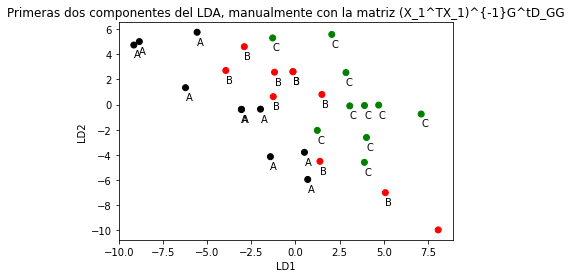

In [104]:
fig, ax = plt.subplots()
colors = {'A':'black', 'B':'red', 'C':'green'}
x_ax=values_centered['componentes_lda'][:,0].tolist()
y_ax=values_centered['componentes_lda'][:,1].tolist()
ax.scatter(x_ax, y_ax, c=datos_ejemplo['VC'].map(colors))
for i, txt in enumerate(datos_ejemplo['VC'].tolist()):
    plt.annotate(txt, (x_ax[i], y_ax[i]-1))
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("Primeras dos componentes del LDA, manualmente con la matriz (X_1^TX_1)^{-1}G^tD_GG")
plt.show()

Lo comparamos ahora con el LDA de Python. **NO NOS DA IGUAL**. Sinceramente no he podido determinar cuál es el error del código de arriba, he seguido la presentación en la materia al pie de la letra.

In [105]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
lda_comps=lda.fit_transform(datos_ejemplo.drop(['VC'],axis=1), datos_ejemplo['VC'])

In [165]:
lda.intercept_

array([-35.13640927,   2.65984188,  21.28074605])

In [167]:
lda.coef_

array([[ 1.50051309,  0.31073579,  1.99276133, -2.40655449,  0.67771124],
       [-0.18482047, -0.02547355, -0.39678844,  0.68851865, -0.09863428],
       [-1.31569262, -0.28526224, -1.5959729 ,  1.71803584, -0.57907696]])

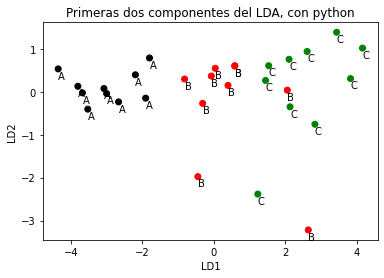

In [106]:
fig, ax = plt.subplots()
colors = {'A':'black', 'B':'red', 'C':'green'}
x_ax=lda_comps[:,0].tolist()
y_ax=lda_comps[:,1].tolist()
offset = (max(y_ax)-min(y_ax))*0.05
ax.scatter(x_ax, y_ax, c=datos_ejemplo['VC'].map(colors))
for i, txt in enumerate(datos_ejemplo['VC'].tolist()):
    plt.annotate(txt, (x_ax[i], y_ax[i]-offset))
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("Primeras dos componentes del LDA, con python")
plt.show()

<div class="alert_container">
    <h3> Comentario: </h3>
    <ul>
        <li> Como tenemos que usar esto para la siguiente pregunta, necesito que el algoritmo dé igual al método de Python. </li>
        <li> Por esta razón decidí programar otro que calcule las componentes principales sin utilizar la matriz $(X_1X_1)^{-1}G^tD_G G$, <strong>si no que vamos a ser un poco más directos y utilizaremos la matriz $V_W^{-1}V_B$ (donde $V_W$ y $V_B$ están definidas en la pregunta 4</strong>). En este caso comprobaremos que las componentes sí dan iguales a las de python. </li>
    </ul>
</div>

Esta función calcula las componentes principales de LDA utilizando la matriz $V_W^{-1}V_B$, utilizando la notación de la pregunta $4$.

In [171]:
def LDA_como_ACP_2(X, y):
    
    # Centramos los datos:
    X_1 = X.copy()
    X_1 = X_1.values
    
    for i in range(X_1.shape[1]):
        X_1[:,i]=[obs-X_1[:,i].mean() for obs in X_1[:,i].tolist()]
    
    n=X_1.shape[0]
    p=X_1.shape[1]
    
    y=y.values
    
    V=np.zeros((p,p))
    for i in range(n):
        x_i=np.matrix(X_1[i,:]).transpose()
        V+=(1/n)*np.matmul(x_i,x_i.transpose())
        
    V_W = np.zeros((p,p))
    V_B = np.zeros((p,p))
    
    valores_clases= np.unique(y)
    r=len(valores_clases)
    
    lista_gs=[]
    
    for s in range(r):
        
        #Calculamos q_s, Aqui p_i=1/n para todo i entonces q_s= |C_s|/n
        X_esta_clase=X_1[y==valores_clases[s],:]
        q_s=X_esta_clase.shape[0]/n
        
        #Calculamos g_s
        g_s=np.matrix((1/q_s)*sum([(1/n)*X_esta_clase[i,:] for i in range(X_esta_clase.shape[0])])).transpose()
        # Guardamos g_s en una lista.
        lista_gs.append({'Clase': valores_clases[s], 'g_s':g_s})
        
        #Sumamos a V_W:
        V_s=np.zeros((p,p))
        for i in range(X_esta_clase.shape[0]):
            dif=np.matrix(X_esta_clase[i,:]).transpose() - g_s
            V_s+=(1/n)*np.matmul(dif,dif.transpose())
        V_W+=V_s
        
        #Sumamos a V_B:
        V_B+= q_s*np.matmul(g_s,g_s.transpose())
        
    # Matriz para ACP:
    acp_Mat= np.matmul(np.linalg.inv(V_W),V_B)
    
    # Finalmente regresamos las componentes del LDA:
    eigs=np.linalg.eig(acp_Mat)
    
    # De acuerdo a la documentacion de eig en numpy, los valores propios no necesariamente se regresan ordenados.
    # Asi que los ordenamos y ademas ordenamos los vectores propios correspondientes.
    
    orders=np.argsort(eigs[0])[::-1]
    vect_mat_temp=eigs[1].copy()
    for i in range(len(eigs[0])):
        vect_mat_temp[:,i]=eigs[1][:,orders[i]]
        
    ### Finalmente las componentes se obtienen al multiplicar X_1 por los vectores propios.
    componentes_lda=np.matmul(X_1,vect_mat_temp)
        
    val_props=list(eigs[0])
    val_props.sort(reverse=True)
        
    return {
        'X_1':X_1,
        'V':V,
        'V_B':V_B,
        'V_W':V_W,
        'g_s':lista_gs,
        'acp_Mat':acp_Mat,
        'val_propios':val_props,
        'vect_propios':vect_mat_temp,
        'componentes_lda':componentes_lda
    }

Componentes principales del LDA utilizando esta segunda función (que es la que se utiliza en el algoritmo en python):

In [172]:
valores_lda_acp=LDA_como_ACP_2(datos_ejemplo.drop(['VC'],axis=1),datos_ejemplo['VC'])

In [258]:
valores_lda_acp['vect_propios']

array([[-0.44023062,  0.14823387,  0.09644516,  0.01899351, -0.30378293],
       [-0.09263528,  0.06950004, -0.17068138,  0.38145805,  0.13718725],
       [-0.5672756 , -0.26190222, -0.23579236, -0.45087003,  0.66665595],
       [ 0.66103646,  0.9508748 , -0.8301921 , -0.79059241, -0.61394779],
       [-0.1970911 ,  0.02099542,  0.46556335,  0.16065135,  0.25987218]])

Ahora hacemos el gráfico de las dos primeras componentes al utilizar esta función y vemos que concuerda con el gráfico obtenido en python.valores_lda_acp['componentes_lda']

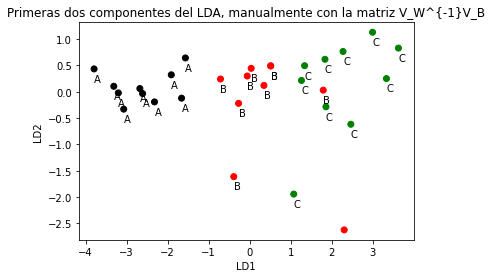

In [235]:
ax_1 = valores_lda_acp['componentes_lda'][:,0].tolist()
ax_2 = valores_lda_acp['componentes_lda'][:,1].tolist()

# Cambiemos la orientacion del segundo eje.
ax_2 = [-1*val for val in ax_2]
offset = (max(ax_2)-min(ax_1))*0.05
fig, ax = plt.subplots()
colors = {'A':'black', 'B':'red', 'C':'green'}
ax.scatter(ax_1, ax_2, c=datos_ejemplo['VC'].map(colors))
for i, txt in enumerate(datos_ejemplo['VC'].tolist()):
    plt.annotate(txt, (ax_1[i], ax_2[i]-offset))
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("Primeras dos componentes del LDA, manualmente con la matriz V_W^{-1}V_B")
plt.show()

**¡Ahora sí! Hemos obtenido lo mismo que el algoritmo de python**
En la pregunta que sigue utilizaré este algoritmo (es decir las componentes del PCA para LDA las voy a calcular con la matriz $V_W^{-1}V_B$). **En realidad esta matriz debería ser igual a la matriz $(X_1X_1)^{-1}G^tD_G G$, así que no debería haber diferencia alguna, pero no estoy seguro qué pasó acá.**

<div class='question_container'>
    <h2> Pregunta 3 </h2>
    <p>Diseñe un algoritmo en pseudocódigo para el Método del Análisis Discriminante Lineal según la teoría vista en clase. Luego agregue a la clase Analisis Predictivo, desarrollada en <code>Python</code>, métodos para el algoritmo diseñado anteriormente, también incluya métodos para el gráfico del plano principal y del círculo de correlaciones. Compare los resultados con respecto a usar modelo = lda en Python, para esto use el archivo de datos <code>Ejemplo_AD.csv</code>.</p>
</div>

Para esto creamos una clase de LDA propia. Lo que tenemos que hacer es básicamente el método `predict` utilizando las componentes principales del LDA. 

In [231]:
class LDA_propio():
    
    def __init__(self,n_components=2):
        self.n_components=n_components
        
    def fit(self, X, y):
        
        self.X=X
        self.y=y
        
        valores_lda=LDA_como_ACP_2(X, y) ### Usamos la funcion anterior para calcular las componentes del ACP.
        
        self.X_1=valores_lda['X_1'] ### Matriz escalada
        self.V=valores_lda['V']
        self.V_B=valores_lda['V_B']
        self.V_W=valores_lda['V_W']
        self.scalings_=valores_lda['vect_propios']
        self.componentes_lda= valores_lda['componentes_lda'][:,range(0,self.n_components)]
    
    def plot_principal_axis(self):
        
        ax_1 = self.componentes_lda[:,0].tolist()
        ax_2 = self.componentes_lda[:,1].tolist()
        
        offset = (max(ax_2)-min(ax_1))*0.03
        fig, ax = plt.subplots()
        colors_list=['black','red','green','yellow','blue']
        colors = {}
        for i in range(len(np.unique(self.y))):
            colors[np.unique(self.y)[i]]=colors_list[i]
        
        ax.scatter(ax_1, ax_2, c=self.y.map(colors))
        for i, txt in enumerate(self.y.tolist()):
            plt.annotate(txt, (ax_1[i], ax_2[i]-offset))
        plt.xlabel("LD1")
        plt.ylabel("LD2")
        plt.title("Primeras dos componentes del LDA")
        plt.show()
    
    def plot_correlation_circle(self):
        
        ### Calculamos las correlaciones de las variables con las componentes del LDA.
        ax_1=[np.corrcoef(self.componentes_lda[:,0],self.X_1[:,j])[0,1] for j in range(self.X_1.shape[1])]
        ax_2=[np.corrcoef(self.componentes_lda[:,1],self.X_1[:,j])[0,1] for j in range(self.X_1.shape[1])]
        
        offset = (max(ax_2)-min(ax_1))*0.03
        fig, ax = plt.subplots()
        ax.scatter(ax_1, ax_2)
        for j, txt in enumerate(self.X.columns):
            plt.annotate(txt, (ax_1[j], ax_2[j]-offset))
            plt.arrow(0, 0, ax_1[j], ax_2[j])
            
        circ = Circle((0,0),1,color='b', fill=False)
        ax.add_patch(circ)
        
        ax.set_aspect('equal')

        plt.xlabel("LD1")
        plt.ylabel("LD2")
        plt.title("Circulo de correlaciones para LDA (primeras dos componentes).")
        plt.show()
        
    def predict(self, X_test):
        
        """
        Para el predict de datos nuevos tenemos que utilizar las componentes principales del LDA que acabamos de calcular.
        La pregunta es cómo calcular la función de decisión con este plano.
        """
        return None

In [232]:
mi_lda=LDA_propio(n_components=2)
mi_lda.fit(datos_ejemplo.drop(['VC'],axis=1),datos_ejemplo['VC'])

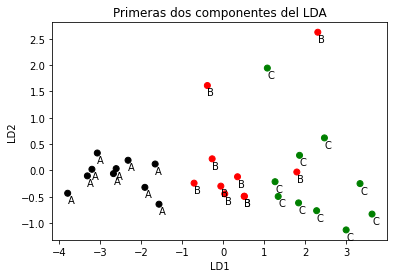

In [233]:
mi_lda.plot_principal_axis()

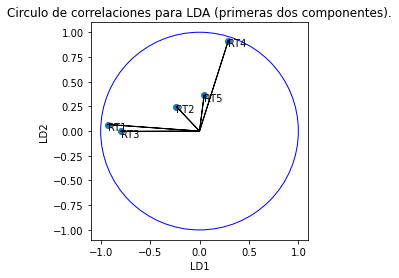

In [234]:
mi_lda.plot_correlation_circle()

Para el predict, debemos crear una frontera de decision utilizando las componentes de LDA. Por falta de tiempo no pude completar esta parte. 😥

<div class="alert_container">
    <h3> Aquí tenía una pregunta:</h3>
    <p> Una vez que tenemos las componentes del LDA la idea sería crear una frontera de decisión utilizándolas. Siempre que he buscado esto para LDA encuentro que ésta frontera se crea con el enfoque de Bayes, sin embargo entiendo que eso no es lo que se quería en este ejercicio. Entonces mi pregunta es: ¿Cómo se construye la frontera de decisión usando las componentes del LDA? Con el scatterplot de las componentes al que llegamos en este ejercicio yo podría construir la frontera de muchas formas (svm, reg logistica...), pero ¿Cuál es el procedimiento para hacerla con LDA (sin usar Bayes)? </p>
</div>

<div class='question_container'>
    <h2> Pregunta 4 </h2>
    <p>En este ejercicio se generalizan los conceptos de Inercia Total, Inercia Inter-Clases e Inercia Intra-Clases presentados en el curso al caso matricial (en el curso se presentan para el caso de un vector).</p>
    <p>Se consideran $p$ variables continuas (variables explicativas) $x^1,\cdots,x^p$ observadas en una muestra $\Omega$ de $n$ individuos. Cada individuo $i \in \Omega$ se identifica con su vector (fila) de mediciones en $\mathbb{R}^p$; $x_i^t = (x_{i1},\cdots,x_{ip})$ y cada variable $x^j$ con su vector (columna) de valores asumidos $x^j = (x_{1j}, x_{2j}, \cdots, x_{nj})^t$. La variable cualitativa y (a explicar) determina una partición $P = \{C_1,\cdots,C_r\}$, del conjunto de individuos en $r$ grupos.</p>
    <p>Se denota como:<p>
    <ul>
        <li>X la matriz de tamaño $n \times p$ la cual se supone centrada en sus columnas. Como es usual sus columnas son las variables explicativas $x^j$ (previamente centradas) y los individuos $x_i^t$ son sus filas.</li>
        <li>$D = \text{diag}(p_i)$ es la matriz de pesos del conjunto de individuos </li>
        <li>A cada clase $C_s$ se le asigna el peso $q_s$ y centro de gravedad $g_s$ para $s = \{1,\cdots,r\}$ donde:
            $$
            \begin{align*}
            q_s = \sum_{i \in C_s} p_i \quad \text{ y } \quad g_s = \frac{1}{q_s}\sum_{i \in C_s}p_ix_i
            \end{align*}
            $$
            Se escribe $D_q = \text{diag}(q_j)$ la matriz diagonal de los pesos de las $r$ clases.</li>
        <li> Se denota como $C_g$ la matriz cuyas filas son los centros de gravedad $g_s^t$</li>
    </ul>
    <p>Como se supone que las variables son centradas entonces el centro de gravedad del conjunto de todos los individuos $\Omega$ es $g = 0$ y la matriz de covarianza (total) $V$ de las $p$ variables calculadas sobre es:</p>
        $$
        \begin{align*}
        V= X^tDX =\sum_{i=1}^n p_i x_i x_i^t = \sum_{s=1}^r\sum_{i \in C_s} p_i x_i x_i^t.
        \end{align*}
        $$
    <p> Sea $V_s$ la matriz de covarianza de las $p$ variables, calculada sobre los individuos de la s-ésima clase: </p>
        $$
        \begin{align*}
        V_s = \frac{1}{q_s} \sum_{i\in C^s} p_i (x_i - g_s)(x_i - g_s)^t.
        \end{align*}
        $$
    <p> El promedio de estas matrices se define como la matriz de covarianza de todas las clases y se denomina matriz de covarianza intra-clase y se denota como $V_W$:</p>
        $$
        \begin{align*}
        V_W=\sum_{s=1}^r q_sV_s = \sum_{s=1}^r\sum_{i\in C^s} p_i(x_i-g_s)(x_i-g_s)^t.
        \end{align*}
        $$
    <p> Finalmente la matriz $V_B$ de covarianza correspondiente a las $p$ variables calculadas sobre los centros de gravedad, se denomina matriz de covarianza inter-clase, la cual es igual a
    </p>
        $$
        \begin{align*}
        V_B=\sum_{s=1}^r q_sg_sg_s^t = C_g^tD_gC_g.
        \end{align*}
        $$
    <p> Con las definiciones anteriores pruebe lo siguiente: Si $V,V_B,V_W$ son las matrices de covarianza total, inter-clase intra-clase, respectivamente, entonces: </p>
    <ol>
        <li> $V = V_B + V_W$ </li>
        <li> $\sum_{s=1}^r q_sg_s = 0$. Es decir $\text{rang}(C_s) \leq r-1$. </li>
        <li> $\text{rang}(C_g) = \text{rang}(V_B)$.
    </ol>
    <p> Además, para la tabla de datos <code>Ejemplo_AD.csv</code> calcule: $g_A, g_B, g_C, V, V_B, V_W$ y verifique que $V = V_B + V_W$.</p>
</div>

**Respuestas:**

1. Usando las definiciones tenemos que

$$
\begin{align*}
V_W + V_B &= \sum_{s=1}^r\sum_{i\in C^s} p_i(x_i-g_s)(x_i-g_s)^t  + \sum_{s=1}^r q_sg_sg_s^t \\
&= \sum_{s=1}^r\biggl[\sum_{i\in C^s} \biggl(p_i(x_i-g_s)(x_i-g_s)^t\biggr)  + q_sg_sg_s^t \biggr]\\
&= \sum_{s=1}^r\biggl[\sum_{i\in C^s} p_i x_ix_i^t - \sum_{i\in C^s} p_i x_ig_s^t  - \sum_{i\in C^s} p_i x_ig_s^t + \underbrace{\sum_{i\in C^s} p_i g_sg_s^t} + q_sg_sg_s^t \biggr]  (*)\\
\end{align*}
$$

Ahora observe que el término subrayado es igual a

$$
\begin{align*}
\sum_{i\in C^s} p_i g_sg_s^t = g_sg_s^t \sum_{i\in C^s} p_i := q_s g_sg_s^t,
\end{align*}
$$
por definición de $q_s$ y además note que

$$
\sum_{i\in C^s} p_i x_ig_s^t = \biggl(\sum_{i\in C^s} p_i x_i \biggr)g_s^t = q_sg_sg_s^t,
$$

y similarmente 

$$
\sum_{i\in C^s} p_i g_sx_i^t = g_s\biggl(\sum_{i\in C^s} p_i x_i \biggr)^t = q_sg_sg_s^t,
$$

De manera que la expresión $(*)$ queda así:

$$
\begin{align*}
&= \sum_{s=1}^r\biggl[\sum_{i\in C^s} p_i x_ix_i^t - q_sg_sg_s^t  - q_sg_sg_s^t + q_sg_sg_s^t + q_sg_sg_s^t \biggr] \\
&= \sum_{s=1}^r\sum_{i\in C^s} p_i x_ix_i^t \\
&= V.
\end{align*}
$$

Con lo que tenemos el teorema de Fisher.

2. Note que al utilizar la definición de $g_s$ tenemos que

$$
\begin{align*}
\sum_{s=1}^r q_sg_s &:=  \sum_{s=1}^r q_s\cdot \frac{1}{q_s}\sum_{i \in C_s}p_ix_i \\
&=\sum_{s=1}\sum_{i \in C_s}p_ix_i \\
&=\sum_{i=1}^n p_ix_i = \textbf{g} =0,
\end{align*}
$$
porque los datos están centrados. Como $C_g$ está formada por filas por los centros de gravedad $g_s$ y acabamos de ver que éstos son linealmente dependientes, obtenemos que $C_g$ no es de rango completo, es decir que $\text{rang}(C_s) \leq r-1$. ($r$ es el mayor rango de $C_g$ que es de tamaño $r \times r$).

3. $\text{rang}(C_g) = \text{rang}(V_B)$. Observe que $V_B=C_g^tD_qC_g = D_q C_g^tC_g$ (Porque $D_q$ es diagonal, así que conmuta con cualquier otra matriz). La matriz $D_q$ siempre es invertible (porque se forma con las frecuencias de las clases de individuos, que nunca son cero), así que el rango de $D_q C_g^tC_g$ es igual al rango de $C_g^tC_g$. Luego el resultado se sigue de la siguiente proposición:


**Proposición:** Para cualquier matriz $A \in \mathbb{R}^{m\times n}$ se cumple que $\text{rang}(A)=\text{rang}(A^tA)$.\
*Prueba:* Probamos que $x \in \text{Null}(A)$ si y solo si $x\in \text{Null}(A^tA)$, y se seguirá luego del teorema del rango y la nulidad. Vea que si $x \in \text{Null}(A)$ entonces $Ax=0$, lo que implica que $A^tAx=0$ así que $x\in \text{Null}(A^tA)$. Recíprocamente, si $A^tAx=0$, multiplicando por $x^t$ tenemos que $x^tA^tAx=0$ es decir $||Ax||^2=0$ lo que implica que $Ax=0$ y por tanto $x \in \text{Null}(A)$.

Ahora calculamos todos estos valores para el ejemplo. Para esto utilizamos la funcion `LDA_como_ACP2` que presentamos en la pregunta 2, ya que ésta calcula las matrices que deseamos.

In [114]:
valores_ejemplo=LDA_como_ACP_2(datos_ejemplo,'VC')

In [115]:
valores_ejemplo['V']

array([[10.89248889,  1.10971111,  3.32866667, -0.61146667, -3.0812    ],
       [ 1.10971111, 10.83982222,  2.405     ,  0.47153333, -4.52153333],
       [ 3.32866667,  2.405     ,  1.91583333, -0.1175    , -2.41666667],
       [-0.61146667,  0.47153333, -0.1175    ,  0.5929    ,  1.01793333],
       [-3.0812    , -4.52153333, -2.41666667,  1.01793333, 17.26706667]])

In [116]:
valores_ejemplo['V_W']

array([[ 2.91746667, -0.90146667,  0.45073333, -0.0328    , -2.59213333],
       [-0.90146667, 10.3074    ,  1.68203333,  0.59336667, -4.449     ],
       [ 0.45073333,  1.68203333,  0.87696667,  0.094     , -2.23453333],
       [-0.0328    ,  0.59336667,  0.094     ,  0.5279    ,  0.93393333],
       [-2.59213333, -4.449     , -2.23453333,  0.93393333, 17.1348    ]])

In [117]:
valores_ejemplo['V_B']

array([[ 7.97502222,  2.01117778,  2.87793333, -0.57866667, -0.48906667],
       [ 2.01117778,  0.53242222,  0.72296667, -0.12183333, -0.07253333],
       [ 2.87793333,  0.72296667,  1.03886667, -0.2115    , -0.18213333],
       [-0.57866667, -0.12183333, -0.2115    ,  0.065     ,  0.084     ],
       [-0.48906667, -0.07253333, -0.18213333,  0.084     ,  0.13226667]])

Notamos que en efecto $V=V_B+V_W$ en este caso: (Las entradas de la diferencia son muy cercanas a cero [Precisión de la máquina]):

In [118]:
valores_ejemplo['V'] -valores_ejemplo['V_B'] -valores_ejemplo['V_W']

array([[ 8.88178420e-16,  1.66533454e-15,  1.44328993e-15,
        -1.94289029e-16,  4.44089210e-16],
       [ 1.66533454e-15,  1.77635684e-15,  4.44089210e-16,
         0.00000000e+00,  8.88178420e-16],
       [ 1.44328993e-15,  4.44089210e-16,  2.22044605e-16,
         1.38777878e-17,  4.44089210e-16],
       [-1.94289029e-16,  0.00000000e+00,  1.38777878e-17,
        -2.22044605e-16,  1.11022302e-16],
       [ 4.44089210e-16,  8.88178420e-16,  4.44089210e-16,
         1.11022302e-16,  3.55271368e-15]])

Finalmente, mostramos los vectores $g_s$ obtenidos para cada clase:

In [119]:
valores_ejemplo['g_s']

[{'Clase': 'A',
  'g_s': matrix([[ 3.68666667],
          [ 0.84333333],
          [ 1.34      ],
          [-0.35      ],
          [-0.4       ]])},
 {'Clase': 'B',
  'g_s': matrix([[-0.51333333],
          [ 0.09333333],
          [-0.21      ],
          [ 0.25      ],
          [ 0.48      ]])},
 {'Clase': 'C',
  'g_s': matrix([[-3.17333333],
          [-0.93666667],
          [-1.13      ],
          [ 0.1       ],
          [-0.08      ]])}]

<div class='question_container'>
    <h2> Pregunta 5 </h2>
    <p> La tabla de datos novatosNBA.csv contiene diferentes métricas de desempeño de novatos de la NBA en su primera temporada. Para esta tabla, las 21 primeras columnas corresponden a las variables predictoras y la variable Permanencia es la variable a predecir, la cual indica si el jugador permanece en la NBA luego de 5 años. La tabla contiene 1340 filas (individuos) y 21 columnas (variables), con la tabla realice lo siguiente:</p>
    <ul>
        <li> Use LDA y QDA en Python para generar un modelo predictivo para la tabla novatosNBA.csv usando el 80% de los datos para la tabla aprendizaje y un 20% para la tabla testing. Obtenga los índices de precisión e interprete los resultados.</li>
        <li>Construya un DataFrame que compare el modelo generado en el ítem anterior contra los modelos vistos en las clases anteriores para la tabla novatosNBA.csv. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos?</li>
    </ul>
</div>

In [267]:
datos_novatos=pd.read_csv("novatosNBA.csv",sep=";",index_col=0)
datos_novatos.head(5)

,PartidosJugados,MinutosJugados,PuntosPorJuego,PuntosCampoAnotados,PuntosCampoIntentados,PuntosCampoPorcentaje,Puntos3Anotados,Puntos3Intentados,Puntos3Porcentaje,TirosLibresRealizados,TirosLibresIntentados,TirosLibresPorcentaje,RebotesOfensivos,RebotesDefensivos,Rebotes,Asistencias,Robos,Bloqueos,PerdidaBalon,Permanencia
Nombre,,,,,,,,,,,,,,,,,,,,
Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


In [268]:
### Hay datos faltantes:
nas_dict={}
for col in datos_novatos.columns:
    nas_dict[col]=datos_novatos[col].isna().sum()
nas_dict

{'PartidosJugados': 0,
 'MinutosJugados': 0,
 'PuntosPorJuego': 0,
 'PuntosCampoAnotados': 0,
 'PuntosCampoIntentados': 0,
 'PuntosCampoPorcentaje': 0,
 'Puntos3Anotados': 0,
 'Puntos3Intentados': 0,
 'Puntos3Porcentaje': 11,
 'TirosLibresRealizados': 0,
 'TirosLibresIntentados': 0,
 'TirosLibresPorcentaje': 0,
 'RebotesOfensivos': 0,
 'RebotesDefensivos': 0,
 'Rebotes': 0,
 'Asistencias': 0,
 'Robos': 0,
 'Bloqueos': 0,
 'PerdidaBalon': 0,
 'Permanencia': 0}

In [269]:
datos_novatos=datos_novatos.dropna() ### Eliminamos los fatos faltantes por ahora.

In [276]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

analisis_Novatos_lda = Analisis_Predictivo(
    datos_novatos,
    predecir = "Permanencia",
    modelo = lda, 
    train_size = 0.8,
)

analisis_Novatos_qda = Analisis_Predictivo(
    datos_novatos,
    predecir = "Permanencia",
    modelo = qda, 
    train_size = 0.8,
)

In [277]:
### Indices de Prediccion para LDA:
resultados_lda = analisis_Novatos_lda.fit_predict_resultados()


Matriz de Confusión:
[[ 53  48]
 [ 26 139]]

Precisión Global:
0.7218045112781954

Error Global:
0.27819548872180455

Precisión por categoría:
          0         1
0  0.524752  0.842424


In [278]:
### Indices de Prediccion para QDA:
resultados_qda = analisis_Novatos_qda.fit_predict_resultados()


Matriz de Confusión:
[[73 25]
 [71 97]]

Precisión Global:
0.6390977443609023

Error Global:
0.3609022556390977

Precisión por categoría:
          0         1
0  0.744898  0.577381


Observamos que con QDA el enfoque deja de centrarse en la clase del 1 (que recordemos era la clase mayoritaria) y se reparte entre clases. Sin embargo esto implica una disminución de la precisión global. Es curioso que la precisión en la clase 1 es mayor que en la clase 0 con LDA, y con QDA para lo contrario.

Seguidamente comparamos ambos métodos con los resultados de la tarea anterior, en la cual habíamos obtenido el siguiente DataFrame:

In [302]:
comp_T7=pd.DataFrame({
    'Precisión Global': [0.740602, 0.714286, 0.691729, 0.680451, 0.62782 , 0.612782, 0.56391],
    'Error Global':[0.259398, 0.285714, 0.308271, 0.319549, 0.37218, 0.387218, 0.43609],
    'Precisión Positiva (PP)':[0.807229, 0.783133, 0.771084, 0.801205, 0.710843, 0.493976, 0.626506],
    'Precisión Negativa (PN)':[0.63, 0.6, 0.56, 0.48, 0.49, 0.81, 0.46],
    'Proporción de Falsos Positivos (PFP)':[0.37, 0.4, 0.44, 0.52, 0.51, 0.19, 0.54],
    'Proporción de Falsos Negativos (PFN)':[0.192771, 0.216867, 0.228916, 0.198795, 0.289157, 0.506024, 0.373494],
    'Asertividad Positiva (AP)':[0.783626, 0.764706, 0.744186, 0.718919, 0.698225, 0.811881, 0.65822],
    'Asertividad Negativa (AN)':[0.663158, 0.625, 0.595745, 0.592593, 0.505155, 0.490909, 0.425926]
})
comp_T7.index=['SVM','Bosque Aleatorio','XG Boost','ADA Boost','KNN','Naive Bayes','Árbol de Decisión']
comp_T7

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
SVM,0.740602,0.259398,0.807229,0.63,0.37,0.192771,0.783626,0.663158
Bosque Aleatorio,0.714286,0.285714,0.783133,0.60,0.40,0.216867,0.764706,0.625000
XG Boost,0.691729,0.308271,0.771084,0.56,0.44,0.228916,0.744186,0.595745
ADA Boost,0.680451,0.319549,0.801205,0.48,0.52,0.198795,0.718919,0.592593
KNN,0.627820,0.372180,0.710843,0.49,0.51,0.289157,0.698225,0.505155
Naive Bayes,0.612782,0.387218,0.493976,0.81,0.19,0.506024,0.811881,0.490909
Árbol de Decisión,0.563910,0.436090,0.626506,0.46,0.54,0.373494,0.658220,0.425926


Ahora le agregamos los coeficientes para LDA y QDA en este caso.

In [303]:
# Variables Predictoras
X = datos_novatos.drop(['Permanencia'],axis=1)
# Variable a predecir
y = datos_novatos['Permanencia'].ravel()

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

#Estandarizamos los datos para aplicar SVM
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()

for col in X_train.columns:
    sd_col=np.std(X_train[col])
    mean_col=np.mean(X_train[col])
    X_train_scaled[col]=[(obs-mean_col)/sd_col for obs in X_train[col]]
    X_test_scaled[col]=[(obs-mean_col)/sd_col for obs in X_test[col]]

In [304]:
modelos_ajustar=[LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis()]
modelos_nombres=['LDA','QDA']

for i in range(len(modelos_ajustar)):
    modelos_ajustar[i].fit(X_train_scaled.values,y_train)
    prediccion = modelos_ajustar[i].predict(X_test_scaled.values)
    MC = confusion_matrix(y_test, prediccion, labels=list(np.unique(y_train)))
    medidas=MatConf(MC).dict_medidas
    df_este_modelo=pd.DataFrame({})
    for key in list(medidas.keys()):
        df_este_modelo[key]=[medidas[key]]
    df_este_modelo.index=[modelos_nombres[i]]
    comp_T7= comp_T7.append(df_este_modelo)

comp_T8=comp_T7.sort_values(by=['Precisión Global'],ascending=False)
comp_T8

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
SVM,0.740602,0.259398,0.807229,0.630000,0.370000,0.192771,0.783626,0.663158
Bosque Aleatorio,0.714286,0.285714,0.783133,0.600000,0.400000,0.216867,0.764706,0.625000
XG Boost,0.691729,0.308271,0.771084,0.560000,0.440000,0.228916,0.744186,0.595745
ADA Boost,0.680451,0.319549,0.801205,0.480000,0.520000,0.198795,0.718919,0.592593
LDA,0.657895,0.342105,0.783951,0.461538,0.538462,0.216049,0.693989,0.578313
QDA,0.639098,0.360902,0.561728,0.759615,0.240385,0.438272,0.784483,0.526667
KNN,0.627820,0.372180,0.710843,0.490000,0.510000,0.289157,0.698225,0.505155
Naive Bayes,0.612782,0.387218,0.493976,0.810000,0.190000,0.506024,0.811881,0.490909
Árbol de Decisión,0.563910,0.436090,0.626506,0.460000,0.540000,0.373494,0.658220,0.425926


In [305]:
comp_T8.to_csv("Comparacion_Novatos_T8.csv")

Observamos que LDA y QDA no obtuvieron las mejores precisiones globales. Sin embargo QDA da junto con NaiveBayes un comportamiento particular de enfoque en la clase minoritaria.

<div class='question_container'>
    <h2> Pregunta 6 </h2>
    <p>Este conjunto de datos es originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo del conjunto de datos es predecir de forma diagnóstica si un paciente tiene diabetes o no, basándose en determinadas medidas de diagnóstico incluidas en el conjunto de datos. El conjunto de datos tiene 390 filas y 16 columnas: </p>
    <ul>
        <li><code>X</code>: Id del paciente.</li>
        <li><code>colesterol</code>: Colesterol en mg/dL.</li>
        <li><code>glucosa</code>: Glucosa en mg/dL.</li>
        <li><code>hdl_col</code>: Lipoproteínas (colesterol bueno).</li>
        <li><code>prop_col_hdl</code>: Proporción del colesterol entre el hdl.</li>
        <li><code>edad</code>: Edad del paciente.</li>
        <li><code>genero</code>: Género del paciente.</li>
        <li><code>altura</code>: Altura en pulgadas del paciente.</li>
        <li><code>peso</code>: Peso en libras del paciente.</li>
        <li><code>IMC</code>: índice de masa corporal.</li>
        <li><code>ps_sistolica</code>: Presión arterial sistólica.</li>
        <li><code>ps_diastolica</code>: Presión arterial diastólica.</li>
        <li><code>cintura</code>: Longitud de la cintura en pulgadas.</li>
        <li><code>cadera</code>: Longitud de la cadera en pulgadas.</li>
        <li><code>prop_cin_cad</code>: Proporción de la longitud de la cintura entre la longitud de la cadera.</li>
        <li><code>diabetes</code>: Diagnóstico de la diabetes.</li>
    </ul>
    <p>Realice lo siguiente:</p>
    <ul>
        <li> Cargue en Python la tabla de datos diabetes.csv.</li>
        <li> Use LDA y QDA en Python para generar un modelo predictivo para la tabla diabetes.csv usando el 75% de los datos para la tabla aprendizaje y un 25% para la tabla testing, luego calcule para los datos de testing la matriz de confusión, la precisión global y la precisión para cada una de las dos categorías. ¿Son buenos los resultados? Explique.</li>
        <li>Construya un DataFrame que compare el modelo generado en el ítem anterior contra los modelos vistos vistos en las clases anteriores para la tabla diabetes.csv. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos?</li>
        <li>Repita el ítem 2, pero esta vez seleccione 6 variables predictoras ¿Mejora la predicción?</li>
    </ul>
</div>

In [306]:
datos_diabetes=pd.read_csv("diabetes.csv",index_col=0)
datos_diabetes

,colesterol,glucosa,hdl_chol,prop_col_hdl,edad,genero,altura,peso,IMC,ps_sistolica,ps_diastolica,cintura,caderas,prop_cin_cad,diabetes
1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No_diabetes
2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No_diabetes
3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,No_diabetes
4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No_diabetes
5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No_diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,227,105,44,5.2,83,female,59,125,25.2,150,90,35,40,0.88,No_diabetes
387,226,279,52,4.3,84,female,60,192,37.5,144,88,41,48,0.85,Diabetes
388,301,90,118,2.6,89,female,61,115,21.7,218,90,31,41,0.76,No_diabetes
389,232,184,114,2.0,91,female,61,127,24.0,170,82,35,38,0.92,Diabetes


In [307]:
#Convertimos a Dummy algunas de las variables predictoras
datos_diabetes_dum = pd.get_dummies(datos_diabetes, columns=['genero'])
datos_diabetes_dum.head(5)

,colesterol,glucosa,hdl_chol,prop_col_hdl,edad,altura,peso,IMC,ps_sistolica,ps_diastolica,cintura,caderas,prop_cin_cad,diabetes,genero_female,genero_male
1,193,77,49,3.9,19,61,119,22.5,118,70,32,38,0.84,No_diabetes,1,0
2,146,79,41,3.6,19,60,135,26.4,108,58,33,40,0.83,No_diabetes,1,0
3,217,75,54,4.0,20,67,187,29.3,110,72,40,45,0.89,No_diabetes,1,0
4,226,97,70,3.2,20,64,114,19.6,122,64,31,39,0.79,No_diabetes,1,0
5,164,91,67,2.4,20,70,141,20.2,122,86,32,39,0.82,No_diabetes,1,0


In [308]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

analisis_diabetes_lda = Analisis_Predictivo(
    datos_diabetes_dum,
    predecir = "diabetes",
    modelo = lda, 
    train_size = 0.75,
)

analisis_diabetes_qda = Analisis_Predictivo(
    datos_diabetes_dum,
    predecir = "diabetes",
    modelo = qda, 
    train_size = 0.75,
)

In [309]:
### Indices de Prediccion para LDA:
resultados_lda = analisis_diabetes_lda.fit_predict_resultados()


Matriz de Confusión:
[[10  4]
 [ 2 82]]

Precisión Global:
0.9387755102040817

Error Global:
0.061224489795918324

Precisión por categoría:
   Diabetes  No_diabetes
0  0.714286      0.97619


In [310]:
### Indices de Prediccion para QDA:
resultados_qda = analisis_diabetes_qda.fit_predict_resultados()


Matriz de Confusión:
[[12  2]
 [11 73]]

Precisión Global:
0.8673469387755102

Error Global:
0.13265306122448983

Precisión por categoría:
   Diabetes  No_diabetes
0  0.857143     0.869048


Con QDA nuestra precisión global es peor, sin embargo la predicción en las dos clases es mejor (con LDA la clase Diabetes, que es la clase minoritaria, tenía una precisión más baja). Esto puede ser beneficioso en problemas no balanceados.

Ahora procedemos a comparar con los otros modelos, de la tarea anterior. En la cual obtuvimos el siguiente DataFrame de comparación:

In [327]:
### Olvidé guardarlos como csv en la tarea anterior, así que los copié del html.
valores_tarea_pasada=np.array([0.935897,0.064103,1.000000,0.583333,0.416667,0.000000,0.929577,1.000000,
                               0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000
                               ,0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000,
                               0.910256,0.089744,0.969697,0.583333,0.416667,0.030303,0.927536,0.777778,
                               0.884615,0.115385,0.954545,0.500000,0.500000,0.045455,0.913043,0.666667,
                               0.884615,0.115385,0.939394,0.583333,0.416667,0.060606,0.925373,0.636364,
                               0.884615,0.115385,0.924242,0.666667,0.333333,0.075758,0.938462,0.615385
                              ]).reshape(7,8).transpose()
comp_T7=pd.DataFrame({
    'Precisión Global': valores_tarea_pasada[0].tolist(),
    'Error Global':valores_tarea_pasada[1].tolist(),
    'Precisión Positiva (PP)':valores_tarea_pasada[2].tolist(),
    'Precisión Negativa (PN)':valores_tarea_pasada[3].tolist(),
    'Proporción de Falsos Positivos (PFP)':valores_tarea_pasada[4].tolist(),
    'Proporción de Falsos Negativos (PFN)':valores_tarea_pasada[5].tolist(),
    'Asertividad Positiva (AP)':valores_tarea_pasada[6].tolist(),
    'Asertividad Negativa (AN)':valores_tarea_pasada[7].tolist()
})
comp_T7.index=['SVM','KNN','Bosque Aleatorio','XG Boost','Árbol de Decisión','ADA Boost','Naive Bayes']
comp_T7

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
SVM,0.935897,0.064103,1.000000,0.583333,0.416667,0.000000,0.929577,1.000000
KNN,0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000
Bosque Aleatorio,0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000
XG Boost,0.910256,0.089744,0.969697,0.583333,0.416667,0.030303,0.927536,0.777778
Árbol de Decisión,0.884615,0.115385,0.954545,0.500000,0.500000,0.045455,0.913043,0.666667
ADA Boost,0.884615,0.115385,0.939394,0.583333,0.416667,0.060606,0.925373,0.636364
Naive Bayes,0.884615,0.115385,0.924242,0.666667,0.333333,0.075758,0.938462,0.615385


Agregamos los valores de precisión para los modelos de esta tarea. Note que los valores son más altos debido a la estandarización.

In [331]:
# Variables Predictoras
X = datos_diabetes.drop(['diabetes'],axis=1)
X = pd.get_dummies(X, columns=['genero'])

# Variable a predecir
y = datos_diabetes['diabetes'].ravel()

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

#Estandarizamos los datos para aplicar SVM
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()

for col in X_train.columns:
    sd_col=np.std(X_train[col])
    mean_col=np.mean(X_train[col])
    X_train_scaled[col]=[(obs-mean_col)/sd_col for obs in X_train[col]]
    X_test_scaled[col]=[(obs-mean_col)/sd_col for obs in X_test[col]]
    
modelos_ajustar=[LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis()]
modelos_nombres=['LDA','QDA']

for i in range(len(modelos_ajustar)):
    modelos_ajustar[i].fit(X_train_scaled.values,y_train)
    prediccion = modelos_ajustar[i].predict(X_test_scaled.values)
    MC = confusion_matrix(y_test, prediccion, labels=list(np.unique(y_train)))
    medidas=MatConf(MC).dict_medidas
    df_este_modelo=pd.DataFrame({})
    for key in list(medidas.keys()):
        df_este_modelo[key]=[medidas[key]]
    df_este_modelo.index=[modelos_nombres[i]]
    comp_T7= comp_T7.append(df_este_modelo)

comp_T8=comp_T7.sort_values(by=['Precisión Global'],ascending=False)
comp_T8

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
LDA,0.974359,0.025641,0.986111,0.833333,0.166667,0.013889,0.986111,0.833333
QDA,0.935897,0.064103,0.972222,0.500000,0.500000,0.027778,0.958904,0.600000
SVM,0.935897,0.064103,1.000000,0.583333,0.416667,0.000000,0.929577,1.000000
KNN,0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000
Bosque Aleatorio,0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000
XG Boost,0.910256,0.089744,0.969697,0.583333,0.416667,0.030303,0.927536,0.777778
LDA,0.887755,0.112245,1.000000,0.476190,0.523810,0.000000,0.875000,1.000000
Árbol de Decisión,0.884615,0.115385,0.954545,0.500000,0.500000,0.045455,0.913043,0.666667
ADA Boost,0.884615,0.115385,0.939394,0.583333,0.416667,0.060606,0.925373,0.636364
Naive Bayes,0.884615,0.115385,0.924242,0.666667,0.333333,0.075758,0.938462,0.615385


Lo que sucede acá es que obtuvimos una mejor precisión global con los modelos de LDA y QDA, en comparación al resto de modelos de la tarea anterior.

In [332]:
comp_T8.to_csv("Comparacion_Diabetes_T8.csv")

En la Tarea anterior habiamos seleccionado 6 variables mediante un algoritmo de Bosques Aleatorios. Vamos a usar esas mismas acá para comparar.

In [334]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

analisis_diabetes_lda_6 = Analisis_Predictivo(
    datos_diabetes[['glucosa','prop_col_hdl','edad','IMC','colesterol','ps_sistolica','diabetes']],
    predecir = "diabetes",
    modelo = lda, 
    train_size = 0.75,
)

analisis_diabetes_qda_6 = Analisis_Predictivo(
    datos_diabetes[['glucosa','prop_col_hdl','edad','IMC','colesterol','ps_sistolica','diabetes']],
    predecir = "diabetes",
    modelo = qda, 
    train_size = 0.75,
)

In [335]:
### Indices de Prediccion para LDA:
resultados_lda_6 = analisis_diabetes_lda_6.fit_predict_resultados()


Matriz de Confusión:
[[ 6  8]
 [ 1 83]]

Precisión Global:
0.9081632653061225

Error Global:
0.09183673469387754

Precisión por categoría:
   Diabetes  No_diabetes
0  0.428571     0.988095


In [336]:
### Indices de Prediccion para QDA:
resultados_qda_6 = analisis_diabetes_qda_6.fit_predict_resultados()


Matriz de Confusión:
[[13  5]
 [ 1 79]]

Precisión Global:
0.9387755102040817

Error Global:
0.061224489795918324

Precisión por categoría:
   Diabetes  No_diabetes
0  0.722222       0.9875


La precisión mejora en unos casos pero en otros empeora [Comparando aquí con los resultados del inciso 1 del ejercicio]. En general es similar, por lo que podríamos concluir que estas variables son importantes (y hasta cierto punto suficientes) para el modelo.